# Importing Libraries 

In [1]:
from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
from IPython.core.display import display, HTML

from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import gc



# --- models ---
#from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
#import catboost as cb
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
import joblib
import pickle

# Reduction of Memory :

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def memory_reduction(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'
          .format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Reading Data :

In [3]:
merged_train = pd.read_feather('../input/energy-feature-engineering-2/merged_train.feather')

In [4]:
merged_train.sort_values("timestamp")
merged_train.reset_index(drop=True)         

,index,building_id,meter,timestamp,meter_reading_log1p,weekend,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,IsHoliday,month_group,horizsolar,Sensible_Heat,relative_humidity
0,0,105,0,2016-01-01 00:00:00,3.190624,4,1,0,10.832181,3.8,0.0,2.4,NaN,1.0,1,0.0,0.040676,90.575539
1,1,106,0,2016-01-01 00:00:00,0.318163,4,1,0,8.589514,3.8,0.0,2.4,NaN,1.0,1,0.0,0.032254,90.575539
2,2,106,3,2016-01-01 00:00:00,0.000000,4,1,0,8.589514,3.8,0.0,2.4,NaN,1.0,1,0.0,0.032254,90.575539
3,3,107,0,2016-01-01 00:00:00,5.171529,4,1,0,11.487947,3.8,0.0,2.4,NaN,1.0,1,0.0,0.043138,90.575539
4,4,108,0,2016-01-01 00:00:00,4.524668,4,1,0,11.309352,3.8,0.0,2.4,NaN,1.0,1,0.0,0.042468,90.575539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19852315,19852315,1444,0,2016-12-31 23:00:00,2.277267,5,15,3,9.884305,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
19852316,19852316,1445,0,2016-12-31 23:00:00,1.762159,5,15,0,8.366138,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
19852317,19852317,1446,0,2016-12-31 23:00:00,0.000000,5,15,3,9.329545,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN
19852318,19852318,1447,0,2016-12-31 23:00:00,5.078761,5,15,1,10.301458,NaN,NaN,NaN,NaN,NaN,3,0.0,NaN,NaN


In [5]:
merged_train.columns

Index(['index', 'building_id', 'meter', 'timestamp', 'meter_reading_log1p',
       'weekend', 'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'IsHoliday',
       'month_group', 'horizsolar', 'Sensible_Heat', 'relative_humidity'],
      dtype='object')

In [6]:
merged_train["hour"] = merged_train["timestamp"].dt.hour #converting timestamp to hour

In [7]:
merged_train = merged_train.drop(['index',"timestamp"],axis=1)

In [8]:
merged_train = merged_train.drop(['month_group','Sensible_Heat', 'relative_humidity'],axis=1)

In [9]:
merged_train.columns

Index(['building_id', 'meter', 'meter_reading_log1p', 'weekend', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'IsHoliday', 'horizsolar',
       'hour'],
      dtype='object')

In [10]:
target = merged_train['meter_reading_log1p']
merged_train = merged_train.drop(['meter_reading_log1p'], axis=1)

# Training data using LGBM :

In [11]:
#https://www.kaggle.com/gunesevitan/ashrae-lightgbm-1-048-no-leak

cat_features = ["building_id", "site_id", "meter", "primary_use", "weekend",'IsHoliday']#, 'month_group'
params = {
    "objective": "regression","boosting": "gbdt","num_leaves": 1280,"learning_rate": 0.05,
    "feature_fraction": 0.85,"reg_lambda": 2,"metric": "rmse","n_estimators":2000
}

kf = KFold(n_splits=3)
models = []
i = 0
for train_index,valid_index in kf.split(merged_train):
    xx_train = merged_train.loc[train_index]
    yy_train = target.loc[train_index]
    
    xx_valid = merged_train.loc[valid_index]
    yy_valid = target.loc[valid_index]
    
    d_training = lgb.Dataset(xx_train, label=yy_train,categorical_feature=cat_features, free_raw_data=False)
    d_valid = lgb.Dataset(xx_valid, label=yy_valid,categorical_feature=cat_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_valid], verbose_eval=25, early_stopping_rounds=50)
    filename = 'lgb_reg_new'+ str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    i +=1
    models.append(model)
    del xx_train, yy_train, xx_valid, yy_valid, d_training, d_valid
    gc.collect()        

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.08239	valid_1's rmse: 1.24094
[50]	training's rmse: 0.881653	valid_1's rmse: 1.13036
[75]	training's rmse: 0.815702	valid_1's rmse: 1.11899
[100]	training's rmse: 0.776132	valid_1's rmse: 1.1187
[125]	training's rmse: 0.745911	valid_1's rmse: 1.1206
Early stopping, best iteration is:
[83]	training's rmse: 0.801443	valid_1's rmse: 1.11799
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.08648	valid_1's rmse: 1.19972
[50]	training's rmse: 0.890567	valid_1's rmse: 1.06515
[75]	training's rmse: 0.834016	valid_1's rmse: 1.04061
[100]	training's rmse: 0.802273	valid_1's rmse: 1.03658
[125]	training's rmse: 0.775709	valid_1's rmse: 1.03519
[150]	training's rmse: 0.75793	valid_1's rmse: 1.03322
[175]	training's rmse: 0.744338	valid_1's rmse: 1.03238
[200]	training's rmse: 0.734564	valid_1's rmse: 1.03158
[225]	training's rmse: 0.726332	valid_1's rmse: 1.03151
[250]	training'

In [12]:
del merged_train                                              

In [13]:
del model

# Reading test data :

In [14]:
merged_test = pd.read_feather('../input/energy-feature-engineering-2/merged_test.feather')    

In [15]:
merged_test["hour"] = merged_test["timestamp"].dt.hour

In [16]:
merged_test.columns

Index(['index', 'row_id', 'building_id', 'meter', 'timestamp', 'weekend',
       'site_id', 'primary_use', 'square_feet', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'IsHoliday',
       'month_group', 'horizsolar', 'Sensible_Heat', 'relative_humidity',
       'hour'],
      dtype='object')

In [17]:
merged_test = merged_test.drop(['index', 'row_id','timestamp'],axis=1)

In [18]:
merged_test = merged_test.drop(['month_group','Sensible_Heat', 'relative_humidity'],axis=1)

In [19]:
merged_test.shape

(41697600, 13)

# Prediction of Test data :

In [20]:
def pred(X_test, models, batch_size=100000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total   

In [21]:
'''
avg_model = []
for i in range(0,3) : 

    filename = "./lgb_reg_new"+ str(i) +".sav"
    regressor = pickle.load(open(filename,'rb'))
    avg_model.append(regressor)
              '''       

'\navg_model = []\nfor i in range(0,3) : \n\n    filename = "./lgb_reg_new"+ str(i) +".sav"\n    regressor = pickle.load(open(filename,\'rb\'))\n    avg_model.append(regressor)\n              '

In [22]:
avg_model = models

In [23]:
predict_test = pred(merged_test,avg_model)

  0%|          | 0/417 [00:00<?, ?it/s]

iterations 417
predicting 0-th model


  0%|          | 0/417 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/417 [00:00<?, ?it/s]

predicting 2-th model


100%|██████████| 417/417 [06:12<00:00,  1.12it/s]


In [24]:
predict_test = np.expm1(predict_test)                                                                                                                                                                                                                                                                                                            

In [25]:
import joblib
joblib.dump(predict_test, 'predict_test.pkl') 

['predict_test.pkl']

In [32]:
merged_test = pd.read_feather('../input/energy-feature-engineering-2/merged_test.feather')    

In [37]:
sample_submission = pd.read_feather("../input/ashrae-feather-format-for-fast-loading/sample_submission.feather")
sample_submission = memory_reduction(sample_submission)            

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


In [38]:
row_ids = merged_test["row_id"]

In [39]:
sample_submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(predict_test, 0, a_max=None)})
sample_submission['meter_reading'] = sample_submission['meter_reading'].astype('float32')
sample_submission['row_id'] = sample_submission['row_id'].astype('int32')

In [40]:
sample_submission["meter_reading"] = merged_test['meter_reading']

In [41]:
sample_submission.head(25)   

,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666
5,5,13.651204
6,6,260.874513
7,7,502.705590
8,8,717.574038
9,9,513.285268


In [ ]:
sample_submission.to_csv('3foldwith_nanleakdata_lgb.csv',index=False)

In [44]:
sample_submission.info()                            

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   row_id         int32  
 1   meter_reading  float64
dtypes: float64(1), int32(1)
memory usage: 795.3 MB


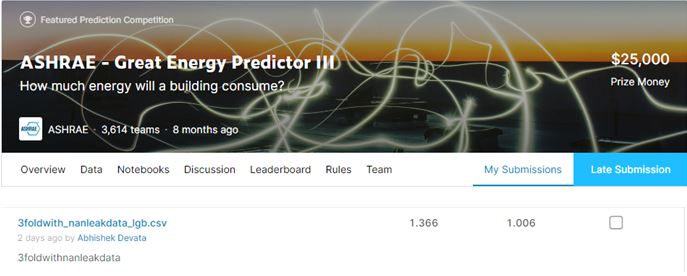

In [1]:
from IPython.display import Image
Image(filename='kfold.JPG')                                                                                                                                                                                                                 